В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [53]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from operator import pos

In [12]:
!pip install pyarrow --quiet

In [2]:
bank_df = pd.read_csv("train.csv")
bank_df.info(), bank_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


(None,
                  id    CustomerId   CreditScore           Age        Tenure  \
 count  15000.000000  1.500000e+04  15000.000000  15000.000000  15000.000000   
 mean    7499.500000  1.569146e+07    658.944133     37.739600      5.025267   
 std     4330.271354  1.352050e+05     72.255926      8.218363      2.776678   
 min        0.000000  1.581102e+06    431.000000     18.000000      0.000000   
 25%     3749.750000  1.563514e+07    603.000000     32.000000      3.000000   
 50%     7499.500000  1.569018e+07    662.000000     37.000000      5.000000   
 75%    11249.250000  1.575718e+07    708.000000     42.000000      7.000000   
 max    14999.000000  1.581569e+07    850.000000     74.000000     10.000000   
 
              Balance  NumOfProducts     HasCrCard  IsActiveMember  \
 count   15000.000000   15000.000000  15000.000000    15000.000000   
 mean    42729.791988       1.590933      0.788800        0.489667   
 std     59727.309419       0.532306      0.408174        0.4

In [87]:
train_val_df, test_df = train_test_split(bank_df, test_size=0.2, random_state=42, stratify=bank_df.Exited)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df.Exited)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [88]:
# exclude id, customer_id, surname and. target column
input_cols = list(train_df.columns)[3:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]
print("input_cols", input_cols)

input_cols ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [89]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()
print("\n numeric_cols", numeric_cols)
print("\n categorical_cols", categorical_cols)


 numeric_cols ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

 categorical_cols ['Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [90]:
# Scaling
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])
# Діапазон значень для числових колонок дуже широкий, є тому потрібно провести масштабування даних,
#  щоб привести їх до однакового діапазону значень


# Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])
pd.set_option('display.max_columns', None)
display(train_inputs.head(5)), display(val_inputs.head(5))
# проведено кодування категоріальних зміниих, оскільки у нас в полі стать два значення та у поля георгафія три,
# то використано OneHotEncoder.
# Стать можна було ще зробити однією колонкою, де для чоловічої буде значення 1, а для жіночої - 0

<ipython-input-90-443e7501de2d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
<ipython-input-90-443e7501de2d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
<ipython-input-90-443e7501de2d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
63,0.744630,France,Male,0.333333,0.5,0.000000,0.333333,0.0,1.0,89893.60,1.0,0.0,0.0,0.0,1.0
13717,0.420048,France,Male,0.314815,0.6,0.000000,0.333333,1.0,1.0,152733.89,1.0,0.0,0.0,0.0,1.0
13292,0.821002,France,Female,0.277778,0.6,0.578527,0.000000,1.0,0.0,141152.28,1.0,0.0,0.0,1.0,0.0
9615,0.369928,Spain,Male,0.555556,0.1,0.000000,0.000000,0.0,1.0,149946.43,0.0,0.0,1.0,0.0,1.0
1618,0.665871,France,Male,0.259259,0.5,0.000000,0.333333,1.0,0.0,68400.14,1.0,0.0,0.0,0.0,1.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
4434,0.305489,France,Male,0.407407,0.7,0.637030,0.000000,0.0,1.0,184581.68,1.0,0.0,0.0,0.0,1.0
8707,0.742243,France,Male,0.296296,0.7,0.000000,0.333333,0.0,1.0,166317.71,1.0,0.0,0.0,0.0,1.0
679,0.816229,France,Male,0.296296,0.7,0.000000,0.333333,1.0,0.0,94003.11,1.0,0.0,0.0,0.0,1.0
4765,0.400955,France,Male,0.388889,0.4,0.000000,0.333333,1.0,1.0,126796.69,1.0,0.0,0.0,0.0,1.0
9354,0.656325,Germany,Female,0.388889,0.9,0.475355,0.333333,1.0,1.0,130404.53,0.0,1.0,0.0,1.0,0.0


(None, None)

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [91]:
train_inputs.to_parquet('train_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')

val_inputs.to_parquet('val_inputs.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

!ls

sample_data	       test.csv   train_inputs.parquet	 val_inputs.parquet
sample_submission.csv  train.csv  train_targets.parquet  val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

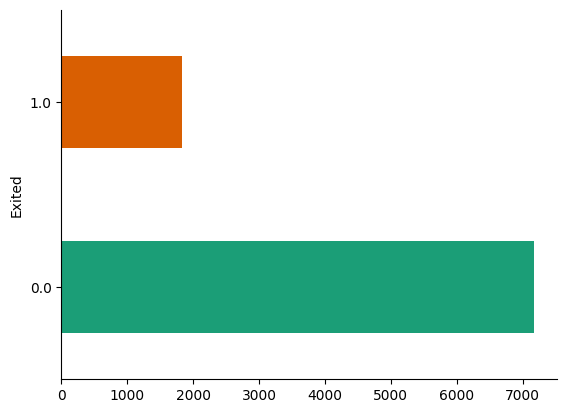

In [92]:
pd.DataFrame(train_targets).groupby('Exited').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

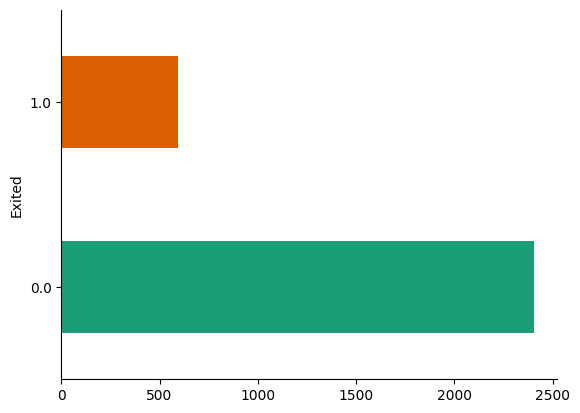

In [80]:
pd.DataFrame(val_targets).groupby('Exited').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Бачимо незбалансованість показників Exited

In [98]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

# використаємо параметр class_weight='balanced', бо маємо незбалансований таргет клас
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, train_targets)

LogisticRegression(class_weight='balanced', solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [94]:
def analyze_model_results(inputs, targets, name='', pos_label = None, threshold=0.5):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]
  y_pred = (y_pred_proba >= threshold).astype(int)

  # f1_score
  f1 = f1_score(targets, y_pred)
  print(f'F1 SCORE for {name}: {f1:.2f}')

  # Accuracy_score
  acc_score = accuracy_score(targets, y_pred)
  print(f'ACCURACY SCORE for {name}: {acc_score:.2f}')

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label = pos_label)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()


F1 SCORE for Training: 0.65
ACCURACY SCORE for Training: 0.82
AUROC for Training: 0.89


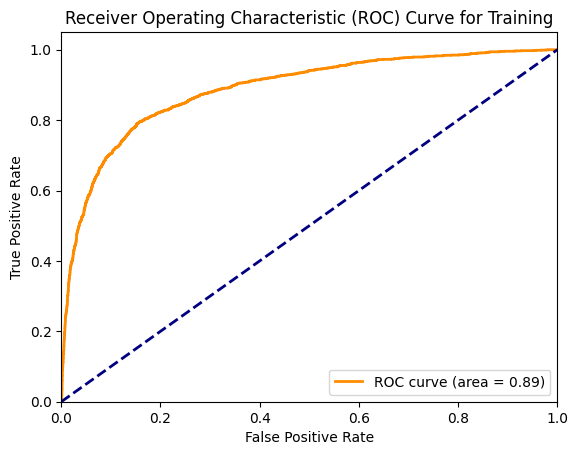

F1 SCORE for Validation: 0.64
ACCURACY SCORE for Validation: 0.82
AUROC for Validation: 0.88


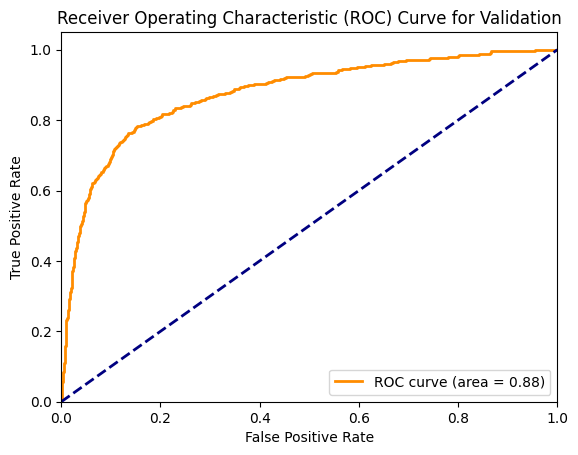

In [104]:
  analyze_model_results(X_train, train_targets, 'Training')
  analyze_model_results(X_val, val_targets, 'Validation')

F1 SCORE for Training: 0.65
ACCURACY SCORE for Training: 0.82
AUROC for Training: 0.89

F1 SCORE for Validation: 0.64
ACCURACY SCORE for Validation: 0.82
AUROC for Validation: 0.88

Загалом бачимо, що модель на тренувальних та валідаційних данихперформить майже однаково, що є добре. Значення AUROC та ACCURACY доволі високе, а от F1 SCORE на рівні 0.65. Припускаємо, що маємо такі результати через незбалансовані значення таргету, хоча і використовували class_weight='balanced'. Без нього модель перформила трохи гірше, але різниця була дуже незначна.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [132]:
from collections import Counter

def all_major(inputs, targets):
  value_counts = Counter(targets)
  most_common = value_counts.most_common(1)[0][0]
  return np.full(len(inputs), most_common)

def random_guess(inputs):
  return np.random.choice([0, 1], len(inputs))
print ("train", "\n random", accuracy_score(train_targets, random_guess(X_train)), "\n all_no", accuracy_score(train_targets, all_major(X_train, train_targets)), "\n model", accuracy_score(train_targets, model.predict(X_train)))
print ("val", "\n random", accuracy_score(val_targets, random_guess(X_val)), "\n all_no", accuracy_score(val_targets, all_major(X_val, val_targets)), "\n model", accuracy_score(val_targets, model.predict(X_val)))

train 
 random 0.5045555555555555 
 all_no 0.7965555555555556 
 model 0.8247777777777778
val 
 random 0.5013333333333333 
 all_no 0.7963333333333333 
 model 0.8203333333333334


Бачимо, що точність моделі краща, аніж якиби всі передбачення були на основі домінуючого значення, тобто модель краща. Але загалом бачимо, що різниця не дуже суттєва, тому модель загалом щадовільна, бо виходить погано передбачає малопредставлений клас.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [134]:
bank_model = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(bank_model, 'bank_model.joblib')
bank_model2 = joblib.load('bank_model.joblib')
bank_model2

{'model': LogisticRegression(class_weight='balanced', solver='liblinear'),
 'scaler': MinMaxScaler(),
 'encoder': OneHotEncoder(handle_unknown='ignore', sparse_output=False),
 'input_cols': ['CreditScore',
  'Geography',
  'Gender',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 'target_col': 'Exited',
 'numeric_cols': ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember'],
 'categorical_cols': ['Geography', 'Gender'],
 'encoded_cols': ['Geography_France',
  'Geography_Germany',
  'Geography_Spain',
  'Gender_Female',
  'Gender_Male']}

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [137]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [139]:
# predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [141]:
test_raw_df = pd.read_csv("test.csv")
predictions = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

test_raw_df['Exited'] = predictions

test_raw_df.head()


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,15594796.0,Chu,0.365155,Germany,Male,0.222222,0.2,0.696265,0.000000,1.0,1.0,157891.86,0.0,1.0,0.0,0.0,1.0,0.223997
1,15001,15642821.0,Mazzi,0.286396,France,Male,0.388889,0.5,0.000000,0.333333,1.0,1.0,67431.28,1.0,0.0,0.0,0.0,1.0,0.146098
2,15002,15716284.0,Onyekachi,0.656325,France,Male,0.462963,0.8,0.000000,0.333333,1.0,0.0,156768.45,1.0,0.0,0.0,0.0,1.0,0.411022
3,15003,15785078.0,Martin,0.682578,Spain,Male,0.500000,0.3,0.000000,0.000000,1.0,1.0,166909.87,0.0,0.0,1.0,0.0,1.0,0.429631
4,15004,15662955.0,Kenechukwu,0.384248,Spain,Male,0.462963,0.8,0.000000,0.333333,1.0,1.0,143681.97,0.0,0.0,1.0,0.0,1.0,0.191551


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [146]:
sample_submission_df = pd.read_csv('sample_submission.csv')
print(sample_submission_df.head())

sample_submission_df['Exited'] = test_raw_df['Exited']
print(sample_submission_df.head())

sample_submission_df.to_csv('submission_log_reg.csv', index=False)
pd.read_csv('submission_log_reg.csv').head()

      id  Exited
0  15000     0.5
1  15001     0.5
2  15002     0.5
3  15003     0.5
4  15004     0.5
      id    Exited
0  15000  0.223997
1  15001  0.146098
2  15002  0.411022
3  15003  0.429631
4  15004  0.191551


,id,Exited
0,15000,0.223997
1,15001,0.146098
2,15002,0.411022
3,15003,0.429631
4,15004,0.191551
